# Pylops - basic linear operators on GPU with cupy

In this notebook I will show how to use some of the basic linear operators implemented in *Pylops* and test both their numpy and cupy backends.

In [1]:
!nvidia-smi

Sun Oct  9 17:00:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 4000     Off  | 00000000:73:00.0 Off |                  N/A |
| 30%   31C    P8     8W / 125W |   1037MiB /  7982MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:A6:00.0  On |                  N/A |
| 51%   

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import timeit
import os
import numpy as np
import cupy as cp
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.sparse.linalg import inv, lsqr
from scipy.sparse import rand

from pylops.utils import dottest
from pylops import LinearOperator
from pylops.basicoperators import *
from pylops.optimization.basic import cgls
from pylops.optimization.leastsquares import *

In [3]:
cp.__version__

'9.6.0'

In [4]:
def timing(cmd_setup, df, method):
    # _matvec
    mat_np = 'Op._matvec(x)'
    mat_cp = 'cOp._matvec(xc)'

    # _matvec
    rmat_np = 'Op._rmatvec(y)'
    rmat_cp = 'cOp._rmatvec(yc)'

    # dry run
    timeit.repeat(mat_cp, setup=cmd_setup, number=1, repeat=1)
    timeit.repeat(rmat_cp, setup=cmd_setup, number=1, repeat=1)

    # timing
    tm_ = 1.e3 * np.array(timeit.repeat(mat_np, setup=cmd_setup,
                                      number=10, repeat=5))
    trm_ = 1.e3 * np.array(timeit.repeat(rmat_np, setup=cmd_setup,
                                      number=10, repeat=5))
    for i in range(5):
        df.loc[len(df)] = [method, True, 'np', tm_[i]]
    for i in range(5):
        df.loc[len(df)] = [method, False, 'np', + trm_[i]]

    tm_ = 1.e3 * np.array(timeit.repeat(mat_cp, setup=cmd_setup,
                                      number=20, repeat=5))
    trm_ = 1.e3 * np.array(timeit.repeat(rmat_cp, setup=cmd_setup,
                                      number=20, repeat=5))
    for i in range(5):
        df.loc[len(df)] = [method, True, 'cp', tm_[i]]
    for i in range(5):
        df.loc[len(df)] = [method, False, 'cp', trm_[i]]
    return df

In [5]:
df = pd.DataFrame(columns=['Method', 'Forw', 'Backend', 'Time'])

## Diagonal

In [6]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = 250000
d = np.arange(n) + 1.
y = x = np.ones(n)
yc = xc = cp.ones(n)
Op = pylops.Diagonal(d)
cOp = pylops.Diagonal(cp.array(d))
"""

df = timing(cmd_setup, df, 'Diagonal')

## Matrix Multiplication

In [7]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = 500
D = np.ones((n, n))
y = x = np.ones(n)
yc = xc = cp.ones(n)
Op = pylops.MatrixMult(D)
cOp = pylops.MatrixMult(cp.array(D))
"""

df = timing(cmd_setup, df, 'MatrixMult')

## Identity

In [8]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = 250000
y = x = np.ones(n)
yc = xc = cp.ones(n)
Op = pylops.Identity(n)
cOp = pylops.Identity(n)
"""

df = timing(cmd_setup, df, 'Identity')

## Zero

In [9]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 500, 500
y = x   = cp.arange(nx)
yc = xc = cp.ones(nx)
Op = pylops.Zero(ny, nx)
cOp = pylops.Zero(ny, nx)
"""

df = timing(cmd_setup, df, 'Zero')

## Sum

In [10]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 500, 500
x = np.ones(nx*ny)
xc = cp.ones(nx*ny)
y = np.ones(nx)
yc = cp.ones(nx)
Op = pylops.Sum(dims=(ny, nx), axis=0)
cOp = pylops.Sum(dims=(ny, nx), axis=0)
"""
df = timing(cmd_setup, df, 'Sum')

## First Derivative

In [11]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 500, 500
x = np.ones(nx*ny)
xc = cp.ones(nx*ny)
y = np.ones(nx*ny)
yc = cp.ones(nx*ny)
Op = pylops.FirstDerivative((ny, nx), axis=0, edge=True)
cOp = pylops.FirstDerivative((ny, nx), axis=0, edge=True)
"""
df = timing(cmd_setup, df, 'FirstDerivative')

## Second Derivative

In [12]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 500, 500
x = np.ones(nx*ny)
xc = cp.ones(nx*ny)
y = np.ones(nx*ny)
yc = cp.ones(nx*ny)
Op = pylops.SecondDerivative((ny, nx), axis=0, edge=True)
cOp = pylops.SecondDerivative((ny, nx), axis=0, edge=True)
"""
df = timing(cmd_setup, df, 'SecondDerivative')

## Laplacian

In [13]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 500, 500
x = np.ones(nx*ny)
xc = cp.ones(nx*ny)
y = np.ones(nx*ny)
yc = cp.ones(nx*ny)
Op = pylops.Laplacian((ny, nx), edge=True)
cOp = pylops.Laplacian((ny, nx), edge=True)
"""
df = timing(cmd_setup, df, 'Laplacian')

## Gradient

In [14]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 500, 500
x = np.ones(nx*ny)
xc = cp.ones(nx*ny)
y = np.ones(nx*ny)
yc = cp.ones(nx*ny)
Op = pylops.Laplacian((ny, nx), edge=True)
cOp = pylops.Laplacian((ny, nx), edge=True)
"""
df = timing(cmd_setup, df, 'Gradient')

## Causal Integration

In [15]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 500, 500
x = np.ones(nx*ny)
xc = cp.ones(nx*ny)
y = np.ones(nx*ny)
yc = cp.ones(nx*ny)
Op = pylops.CausalIntegration((ny, nx), axis=1)
cOp = pylops.CausalIntegration((ny, nx), axis=1)
"""
df = timing(cmd_setup, df, 'CausalIntegration')

## Flip

In [16]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 500, 500
x = np.ones(nx*ny)
xc = cp.ones(nx*ny)
y = np.ones(nx*ny)
yc = cp.ones(nx*ny)
Op = pylops.Flip((ny, nx), axis=1)
cOp = pylops.Flip((ny, nx), axis=1)
"""
df = timing(cmd_setup, df, 'Flip')

## Pad

In [17]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = 250000
pad = (200, 200)
x = np.ones(n)
xc = cp.ones(n)
y = np.ones(n + 400)
yc = cp.ones(n + 400)
Op = pylops.Pad(n, pad)
cOp = pylops.Pad(n, pad)
"""
df = timing(cmd_setup, df, 'Pad')

## Pad

In [18]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = 250000
x = np.ones(n)
xc = cp.ones(n)
y = np.ones(n)
yc = cp.ones(n)
Op = pylops.Roll(n, shift=20)
cOp = pylops.Roll(n, shift=20)
"""
df = timing(cmd_setup, df, 'Roll')

## Symmetrize


In [19]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = 250000
x = np.ones(n)
xc = cp.ones(n)
y = np.ones(n*2-1)
yc = cp.ones(n*2-1)
Op = pylops.Symmetrize(n)
cOp = pylops.Symmetrize(n)
"""
df = timing(cmd_setup, df, 'Symmetrize')

## Restriction

In [20]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = 250000
iava = np.arange(0,n,100)
x = np.ones(n)
xc = cp.ones(n)
y = np.ones(n//100)
yc = cp.ones(n//100)
Op = pylops.Restriction(n, iava)
cOp = pylops.Restriction(n, iava)
"""
df = timing(cmd_setup, df, 'Restriction')

## Transpose

In [21]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 500, 500
x = np.ones(nx*ny)
xc = cp.ones(nx*ny)
y = np.ones(nx*ny)
yc = cp.ones(nx*ny)
Op = pylops.Transpose((ny, nx), axes=(1,0))
cOp = pylops.Transpose((ny, nx), axes=(1,0))
"""
df = timing(cmd_setup, df, 'Transpose')

## FFT

In [22]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = 250000
x = np.ones(n)
xc = cp.ones(n)
y = np.ones(n)
yc = cp.ones(n)
Op = pylops.signalprocessing.FFT(dims=[n], nfft=n)
cOp = pylops.signalprocessing.FFT(dims=[n], nfft=n)
"""
df = timing(cmd_setup, df, 'FFT')

## FFT2D

In [23]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 500, 500
x = np.ones(nx*ny)
xc = cp.ones(nx*ny)
y = np.ones(nx*ny)
yc = cp.ones(nx*ny)
Op = pylops.signalprocessing.FFT2D(dims=[ny, nx])
cOp = pylops.signalprocessing.FFT2D(dims=[ny, nx])
"""
df = timing(cmd_setup, df, 'FFT2D')

## FFTND

In [24]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
nz, ny, nx = 50, 100, 100
x = np.ones(nz*nx*ny)
xc = cp.ones(nz*nx*ny)
y = np.ones(nz*nx*ny)
yc = cp.ones(nz*nx*ny)
Op = pylops.signalprocessing.FFTND(dims=[nz, ny, nx])
cOp = pylops.signalprocessing.FFTND(dims=[nz, ny, nx])
"""
df = timing(cmd_setup, df, 'FFTND')

## Convolve 1D

In [25]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = 250000
x = np.ones(n)
xc = cp.ones(n)
y = np.ones(n)
yc = cp.ones(n)
h = np.ones(40)
hc = cp.ones(40)
Op = pylops.signalprocessing.Convolve1D(n, h)
cOp = pylops.signalprocessing.Convolve1D(n, h)
"""
df = timing(cmd_setup, df, 'Convolve1D')

## ChirpRadon2D

In [26]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
nt, nh = 500, 500
t = np.arange(nt)
h = np.arange(nh)
x = np.ones(nt*nh)
xc = cp.ones(nt*nh)
y = np.ones(nt*nh)
yc = cp.ones(nt*nh)
Op = pylops.signalprocessing.ChirpRadon2D(t, h, 0.001)
cOp = pylops.signalprocessing.ChirpRadon2D(t, h, 0.001)

"""
df = timing(cmd_setup, df, 'ChirpRadon2D')

In [27]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
nt, nh1, nh2 = 100, 50, 50
t = np.arange(nt)
h1 = np.arange(nh1)
h2 = np.arange(nh2)
x = np.ones(nt*nh1*nh2)
xc = cp.ones(nt*nh1*nh2)
y = np.ones(nt*nh1*nh2)
yc = cp.ones(nt*nh1*nh2)
Op = pylops.signalprocessing.ChirpRadon3D(t, h1, h2, (0.001, 0.001), engine='fftw')
cOp = pylops.signalprocessing.ChirpRadon3D(t, h1, h2, (0.001, 0.001))

"""
df = timing(cmd_setup, df, 'ChirpRadon3D')

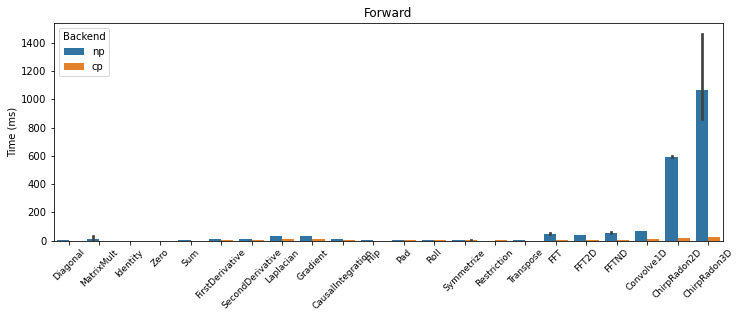

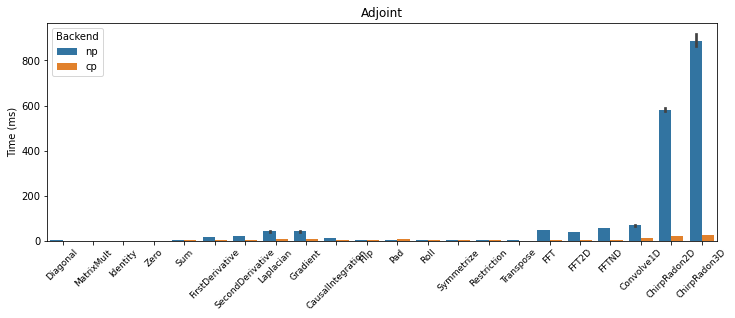

In [28]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x='Method', y='Time', hue='Backend', data=df[df['Forw']==True])
ax.set_xlabel('');
ax.set_ylabel('Time (ms)')
ax.set_title('Forward')
ax.set_xticklabels(df['Method'].unique(),rotation=45, fontsize=9)

fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x='Method', y='Time', hue='Backend', data=df[df['Forw']==False])
ax.set_xlabel('');
ax.set_ylabel('Time (ms)')
ax.set_title('Adjoint')
ax.set_xticklabels(df['Method'].unique(),rotation=45, fontsize=9);